<a href="https://colab.research.google.com/github/mpurkeypile-usd/AAI590-Final_Project/blob/main/AAI590_Final_Project_MPurkeypile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Matt Purkeypile  
AAI590 Capstone: Final Project  
August 2025  

# Breast Tumor Classification Using Quantum Neural Networks

## Setup and library loading

In [63]:
# AFTER THIS CELL FINISHES RUNNING, BE SURE TO RESTART THE SESSION
# (Easiest to just run this cell individually at first, then restart)
#
# the next few cells setting up the resources is based on the following:
# https://www.tensorflow.org/quantum/tutorials/hello_many_worlds
!pip install tensorflow==2.15.0

  Using cached protobuf-4.25.8-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
Using cached protobuf-4.25.8-cp37-abi3-manylinux2014_x86_64.whl (294 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.15.0 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.15.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.15.0 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have pro

In [1]:
# AFTER THIS CELL FINISHES RUNNING, BE SURE TO RESTART THE SESSION
# (Easiest to just run this cell individually at first, then restart)
!pip install tensorflow-quantum==0.7.3

  Using cached protobuf-5.29.5-cp38-abi3-manylinux2014_x86_64.whl.metadata (592 bytes)
Using cached protobuf-5.29.5-cp38-abi3-manylinux2014_x86_64.whl (319 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.8
    Uninstalling protobuf-4.25.8:
      Successfully uninstalled protobuf-4.25.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.29.5 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.15.0 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.15.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.15.0 which is incompatible.


In [1]:
# Should be able to run from this cell and below to run everything
# else all at once.

# Update package resources to account for version changes.
import importlib, pkg_resources

importlib.reload(pkg_resources)

/tmp/ipython-input-1-271731453.py:5: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import importlib, pkg_resources


<module 'pkg_resources' from '/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py'>

In [2]:
# for quantum computing
import tensorflow as tf
import tensorflow_quantum as tfq    # reference: https://www.tensorflow.org/quantum

import cirq                         # reference: https://quantumai.google/cirq/
import cirq_google
from cirq.contrib.svg import SVGCircuit
import sympy

In [38]:
# to load the data
from google.colab import drive

# standard libraries
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from datetime import datetime

## Data Cleaning

In [4]:
# first load the data
# note that the file is also in the github repo and could
# be moved into this location or pulled from there.
# original source of data:
# https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset?resource=download
# downloaded June 2025
drive.mount('/content/gdrive')
DATASET_PATH = '/content/gdrive/My Drive/Colab Notebooks/breast-cancer.csv'
TARGET_COL = 'diagnosis'

raw_data = pd.read_csv(DATASET_PATH)

raw_data.describe()
print()
raw_data.info()
print()
raw_data.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  ra

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_worst  \
0  ...         25.38          17.33           184.60      2019.0   
1  ...         24.99          23.41           158.80      1956.0   
2  ...         23.57          25.53           152.50      1709.0   
3  ...         14.91          26.50            98.87       567.7   
4  ...         22.54          16.67           152.20      1575.0   

   smoothness_worst  compactness_worst  concavity_worst  concave points_worst  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   
2            0.1444             0.4245           0.4504                0.2430   
3            0.2098             0.8663           0.6869                0.2575   
4            0.1374             0.2050           0.4000                0.1625   

   symmetry_worst  fractal_dimension_worst  
0          0.4601                  0.11890  
1          0.2750                  0.08902  
2          0.3613                  0.08758  
3          0.6638                  0.17300  
4          0.2364                  0.07678  

[5 rows x 32 columns]

In [5]:
# add in a new column for the diagnosis as a new binary
# variable: 1 (malignant, cancerous), 0 (benign, non-cancerous)
TARGET_COL_BINARY = 'diagnosis_binary'
raw_data[TARGET_COL_BINARY] = raw_data[TARGET_COL].apply(lambda x: 1 if x == 'M' else 0)

print(raw_data[TARGET_COL_BINARY].value_counts())
print(raw_data[TARGET_COL_BINARY].dtype)

diagnosis_binary
0    357
1    212
Name: count, dtype: int64
int64


In [6]:
# any missing values? (although can see above too)
raw_data.isna().sum()

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
diagnosis_binary           0
dtype: int64

### Data cleaning summary
This data is pretty clean, so nothing really needs to be done to cleanup the data.

## Exploratory Data Analysis

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


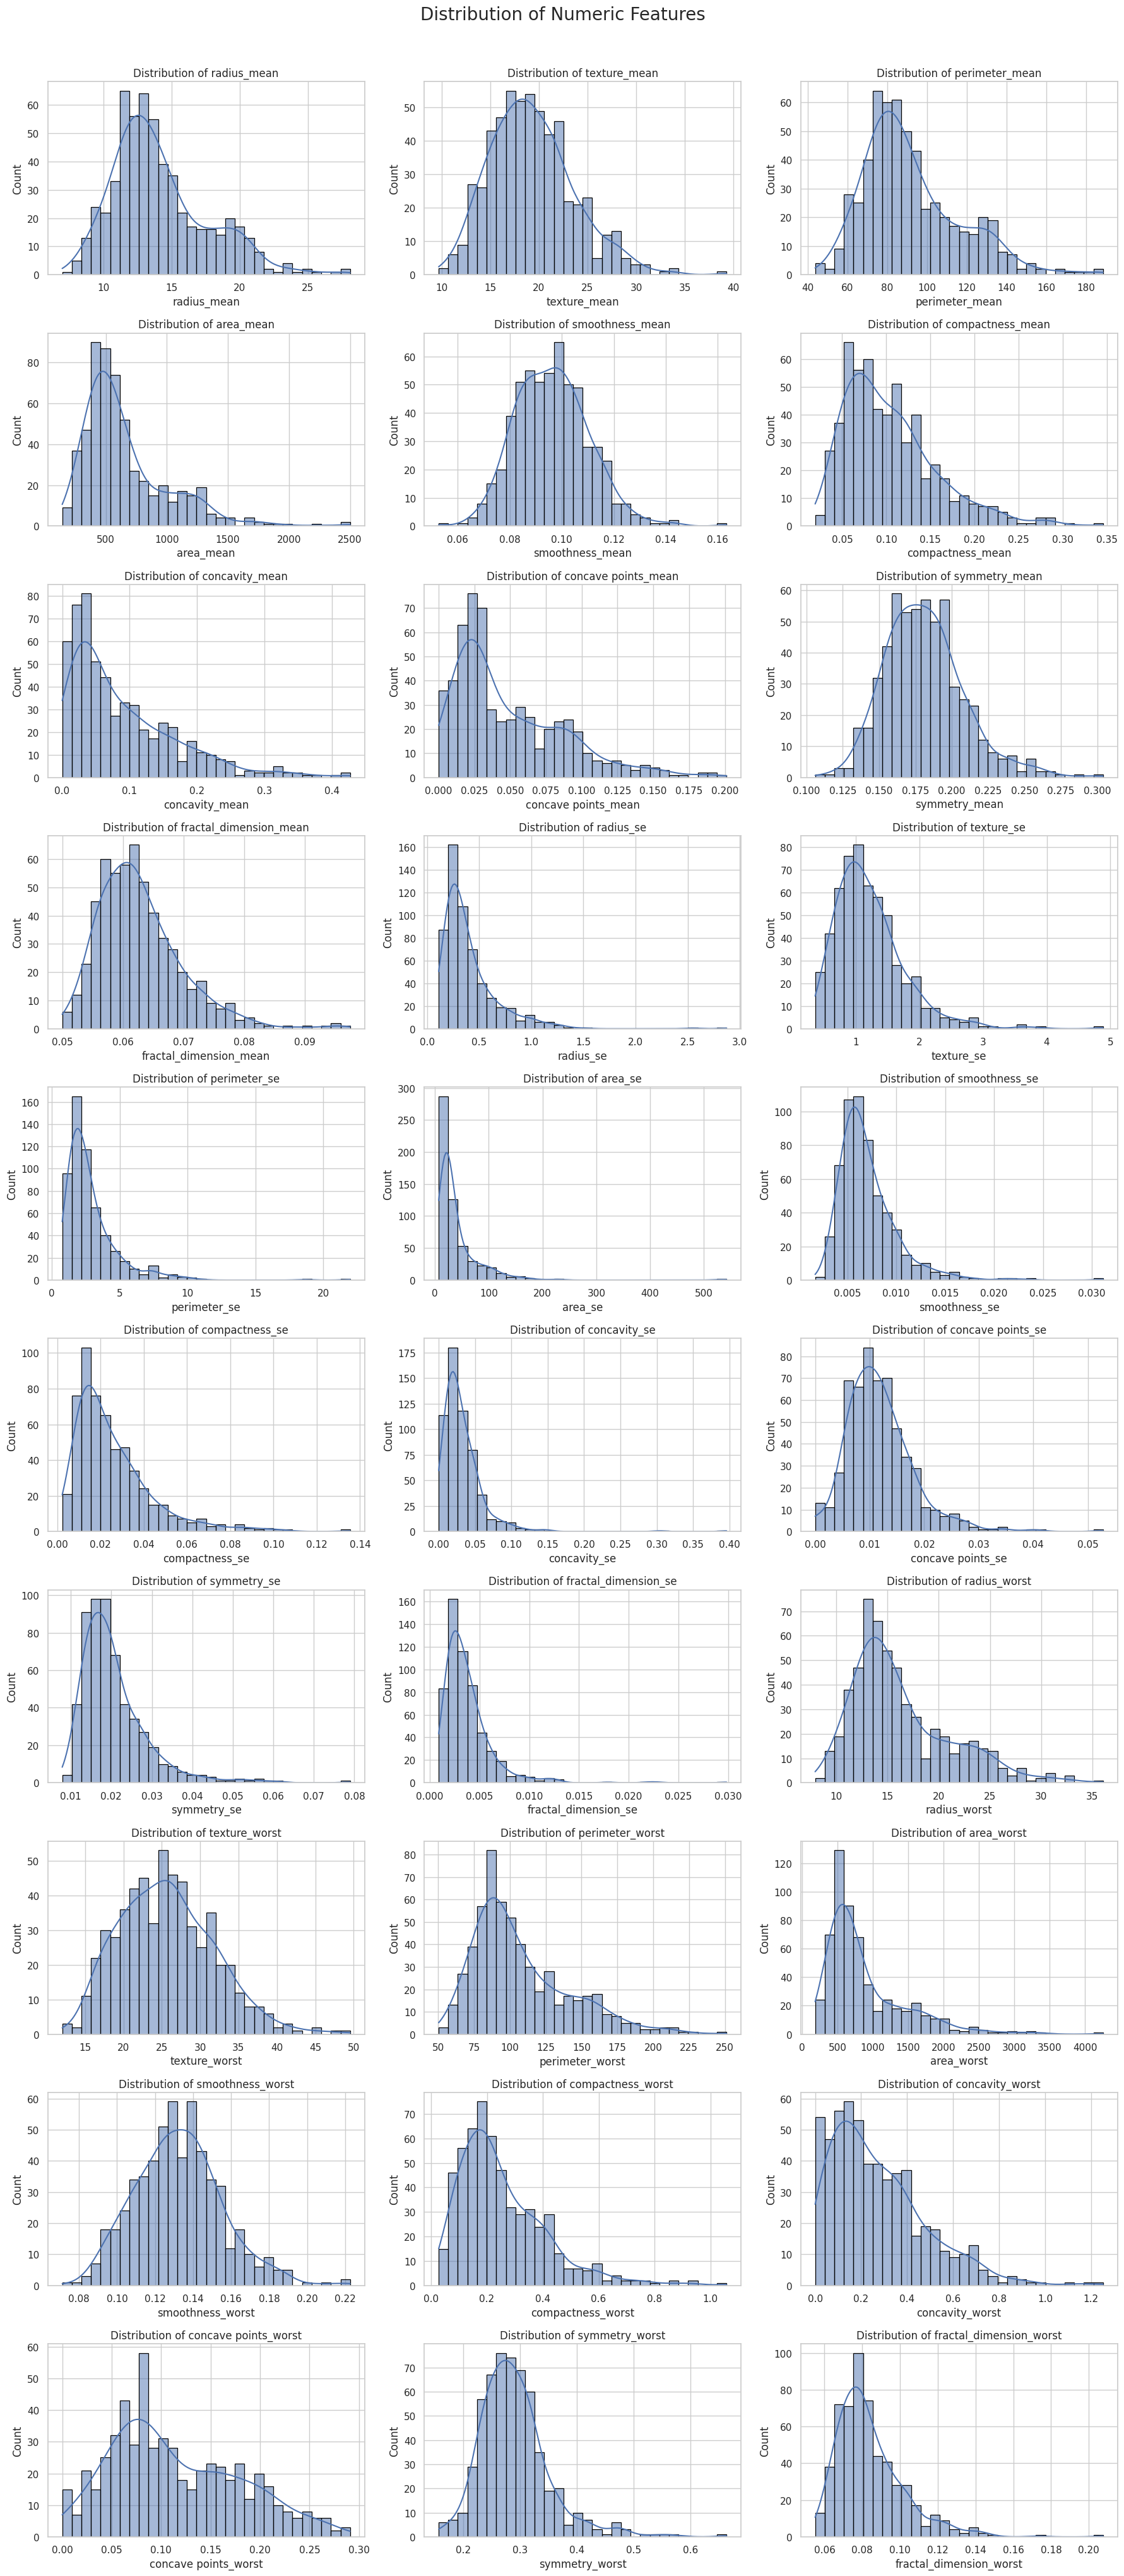

In [7]:
# based on my AAI540 final project
# Select numeric columns
numeric_cols = raw_data.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = numeric_cols.drop('id')
numeric_cols = numeric_cols.drop(TARGET_COL_BINARY)

print(numeric_cols)

# Set plot style
sns.set(style="whitegrid")

# Set up the grid
num_plots = len(numeric_cols)
rows = (num_plots // 3) + (num_plots % 3 > 0)
fig, axes = plt.subplots(rows, 3, figsize=(18, 4 * rows))
axes = axes.flatten()

# Plot distributions
for i, col in enumerate(numeric_cols):
    sns.histplot(raw_data[col], kde=True, ax=axes[i], bins=30, edgecolor='black')
    axes[i].set_title(f'Distribution of {col}')

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Distribution of Numeric Features", fontsize=20, y=1.02)
plt.show()

<Axes: xlabel='diagnosis', ylabel='Count'>

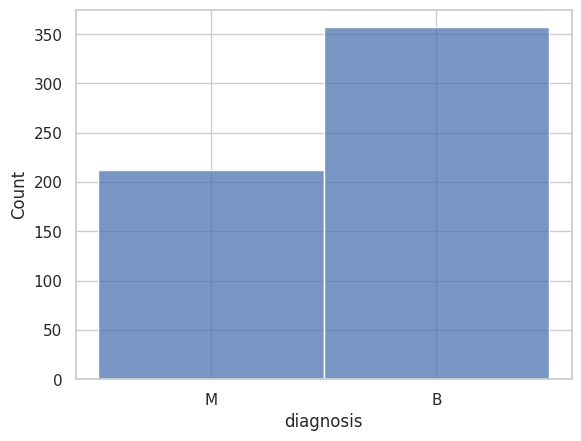

In [8]:
sns.histplot(raw_data[TARGET_COL])

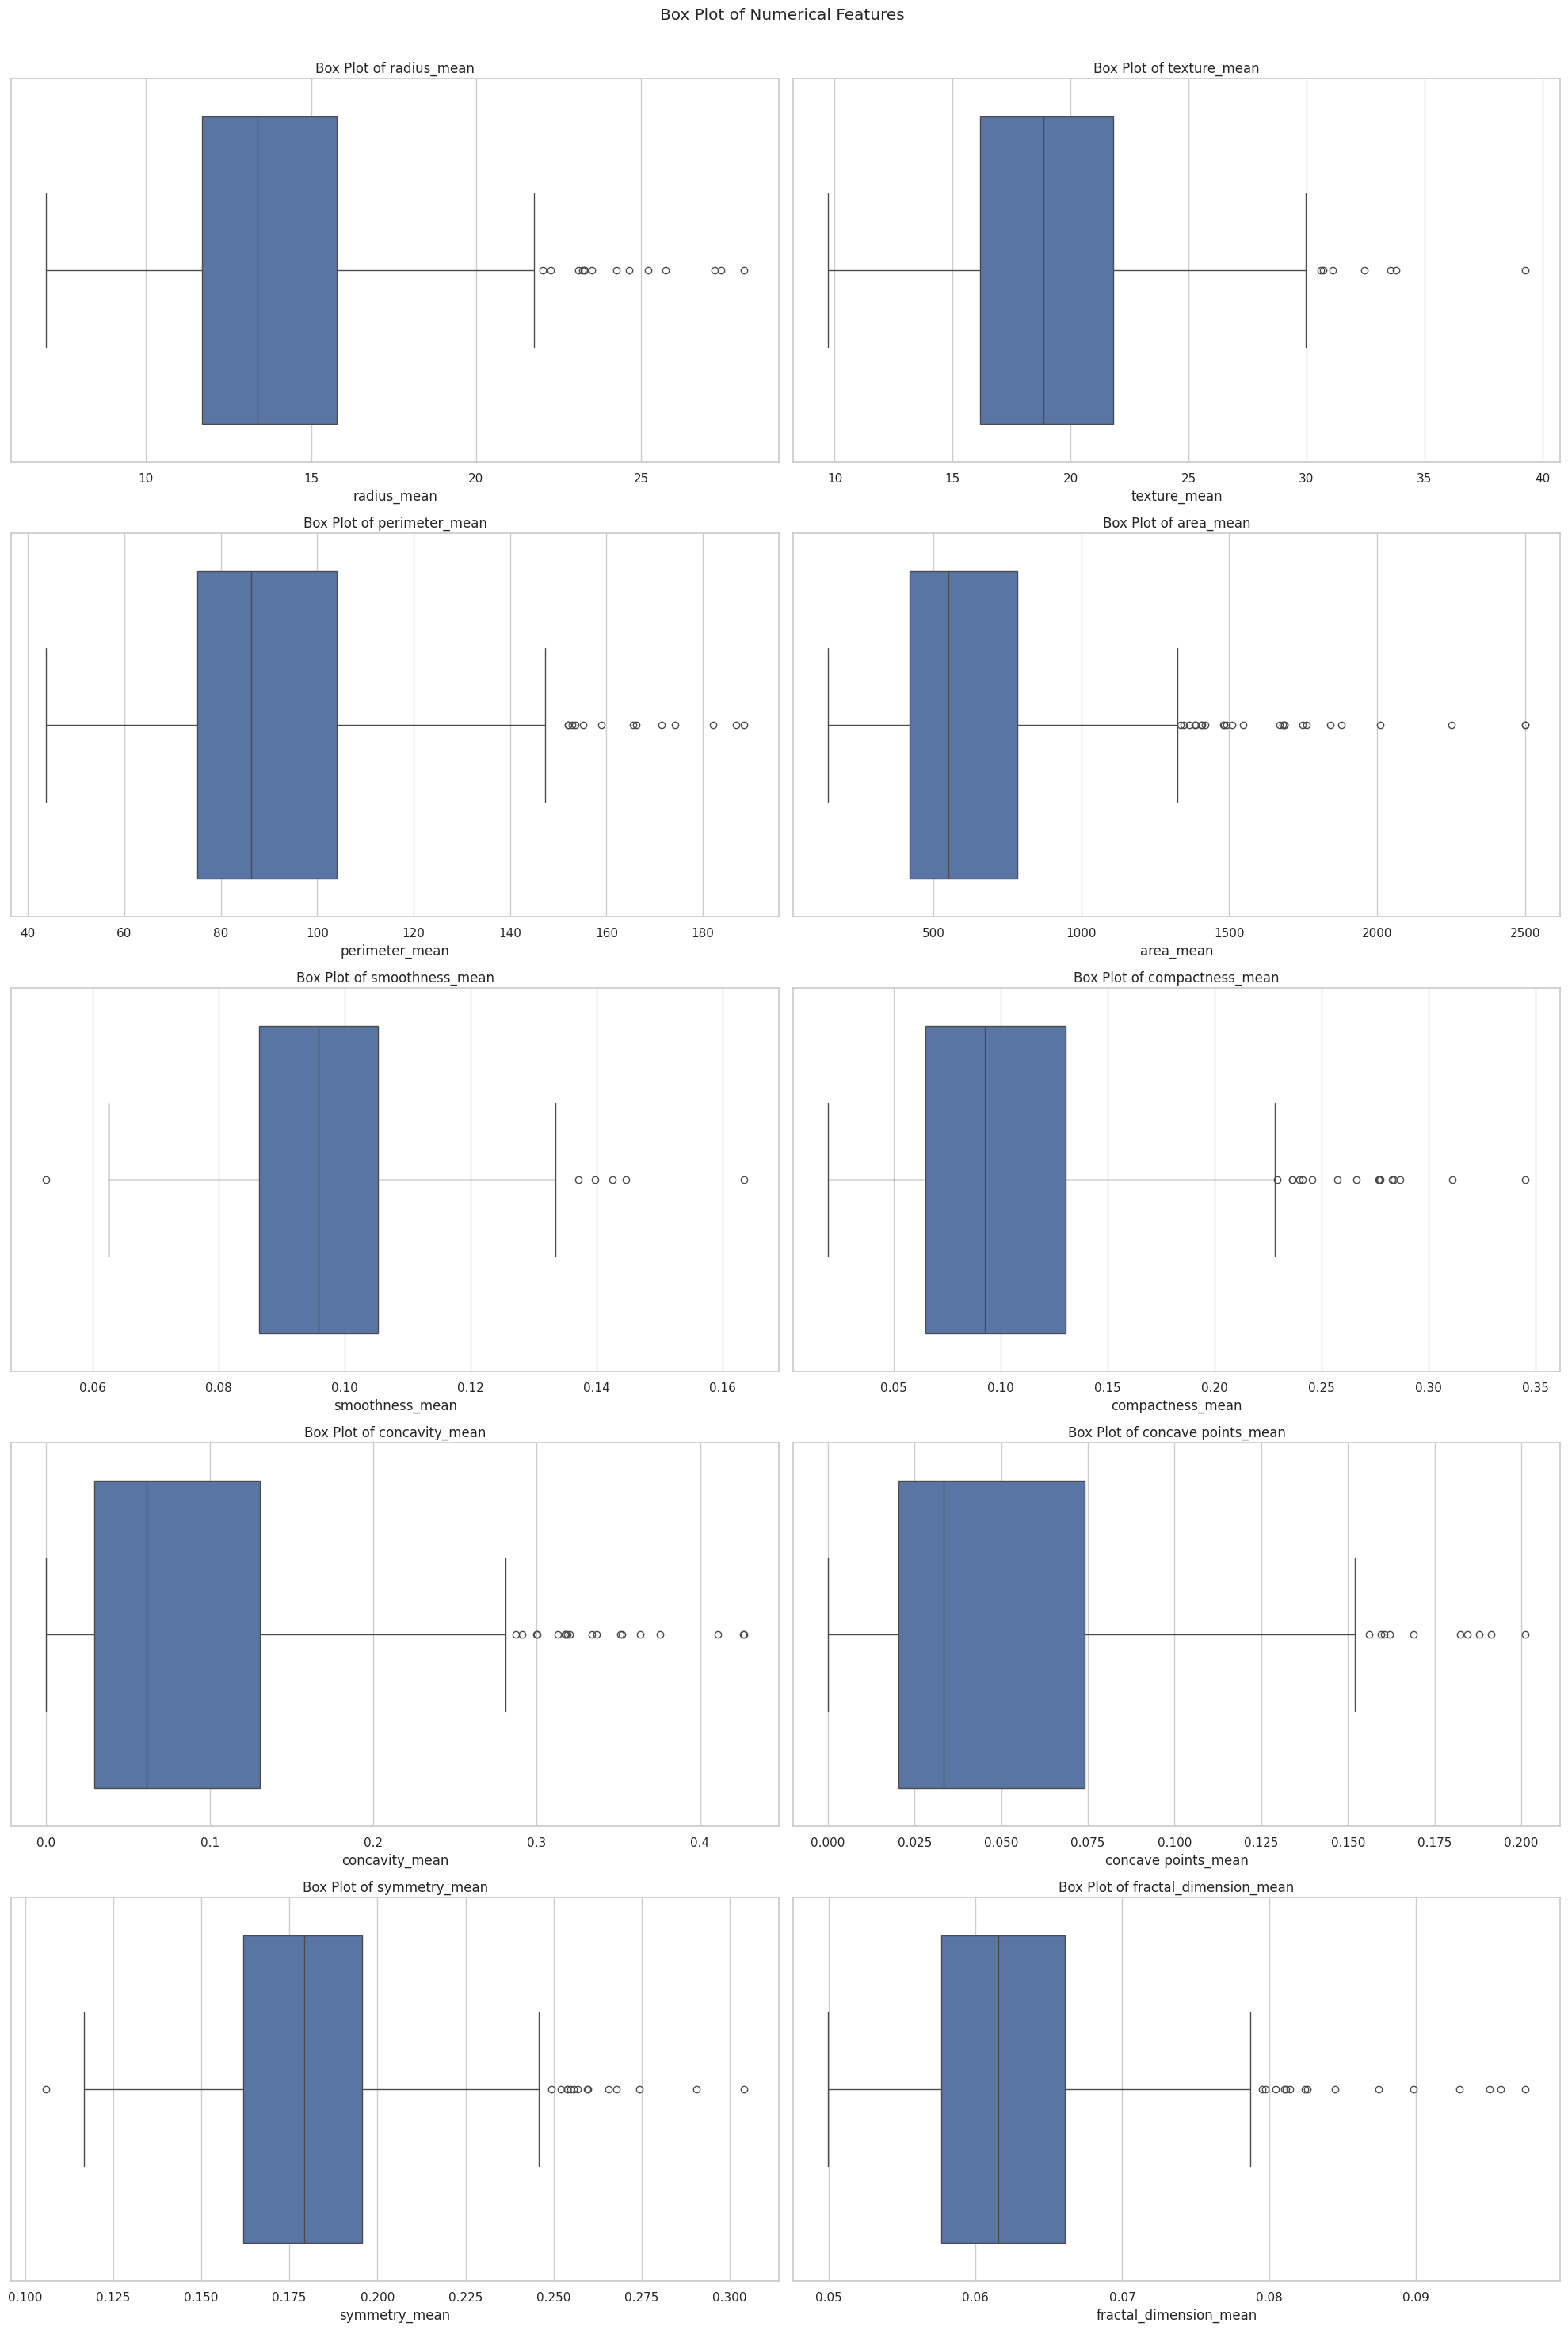

In [9]:
# This cell based on my AAI540 final project
# Check for Outliers
fig, axes = plt.subplots(5, 2, figsize=(20, 30))
fig.suptitle('Box Plot of Numerical Features')

# Iterating over numerical columns
for col, ax in zip(numeric_cols, axes.flatten()):
    sns.boxplot(data=raw_data, x=col, ax=ax)
    ax.set_title(f'Box Plot of {col}')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

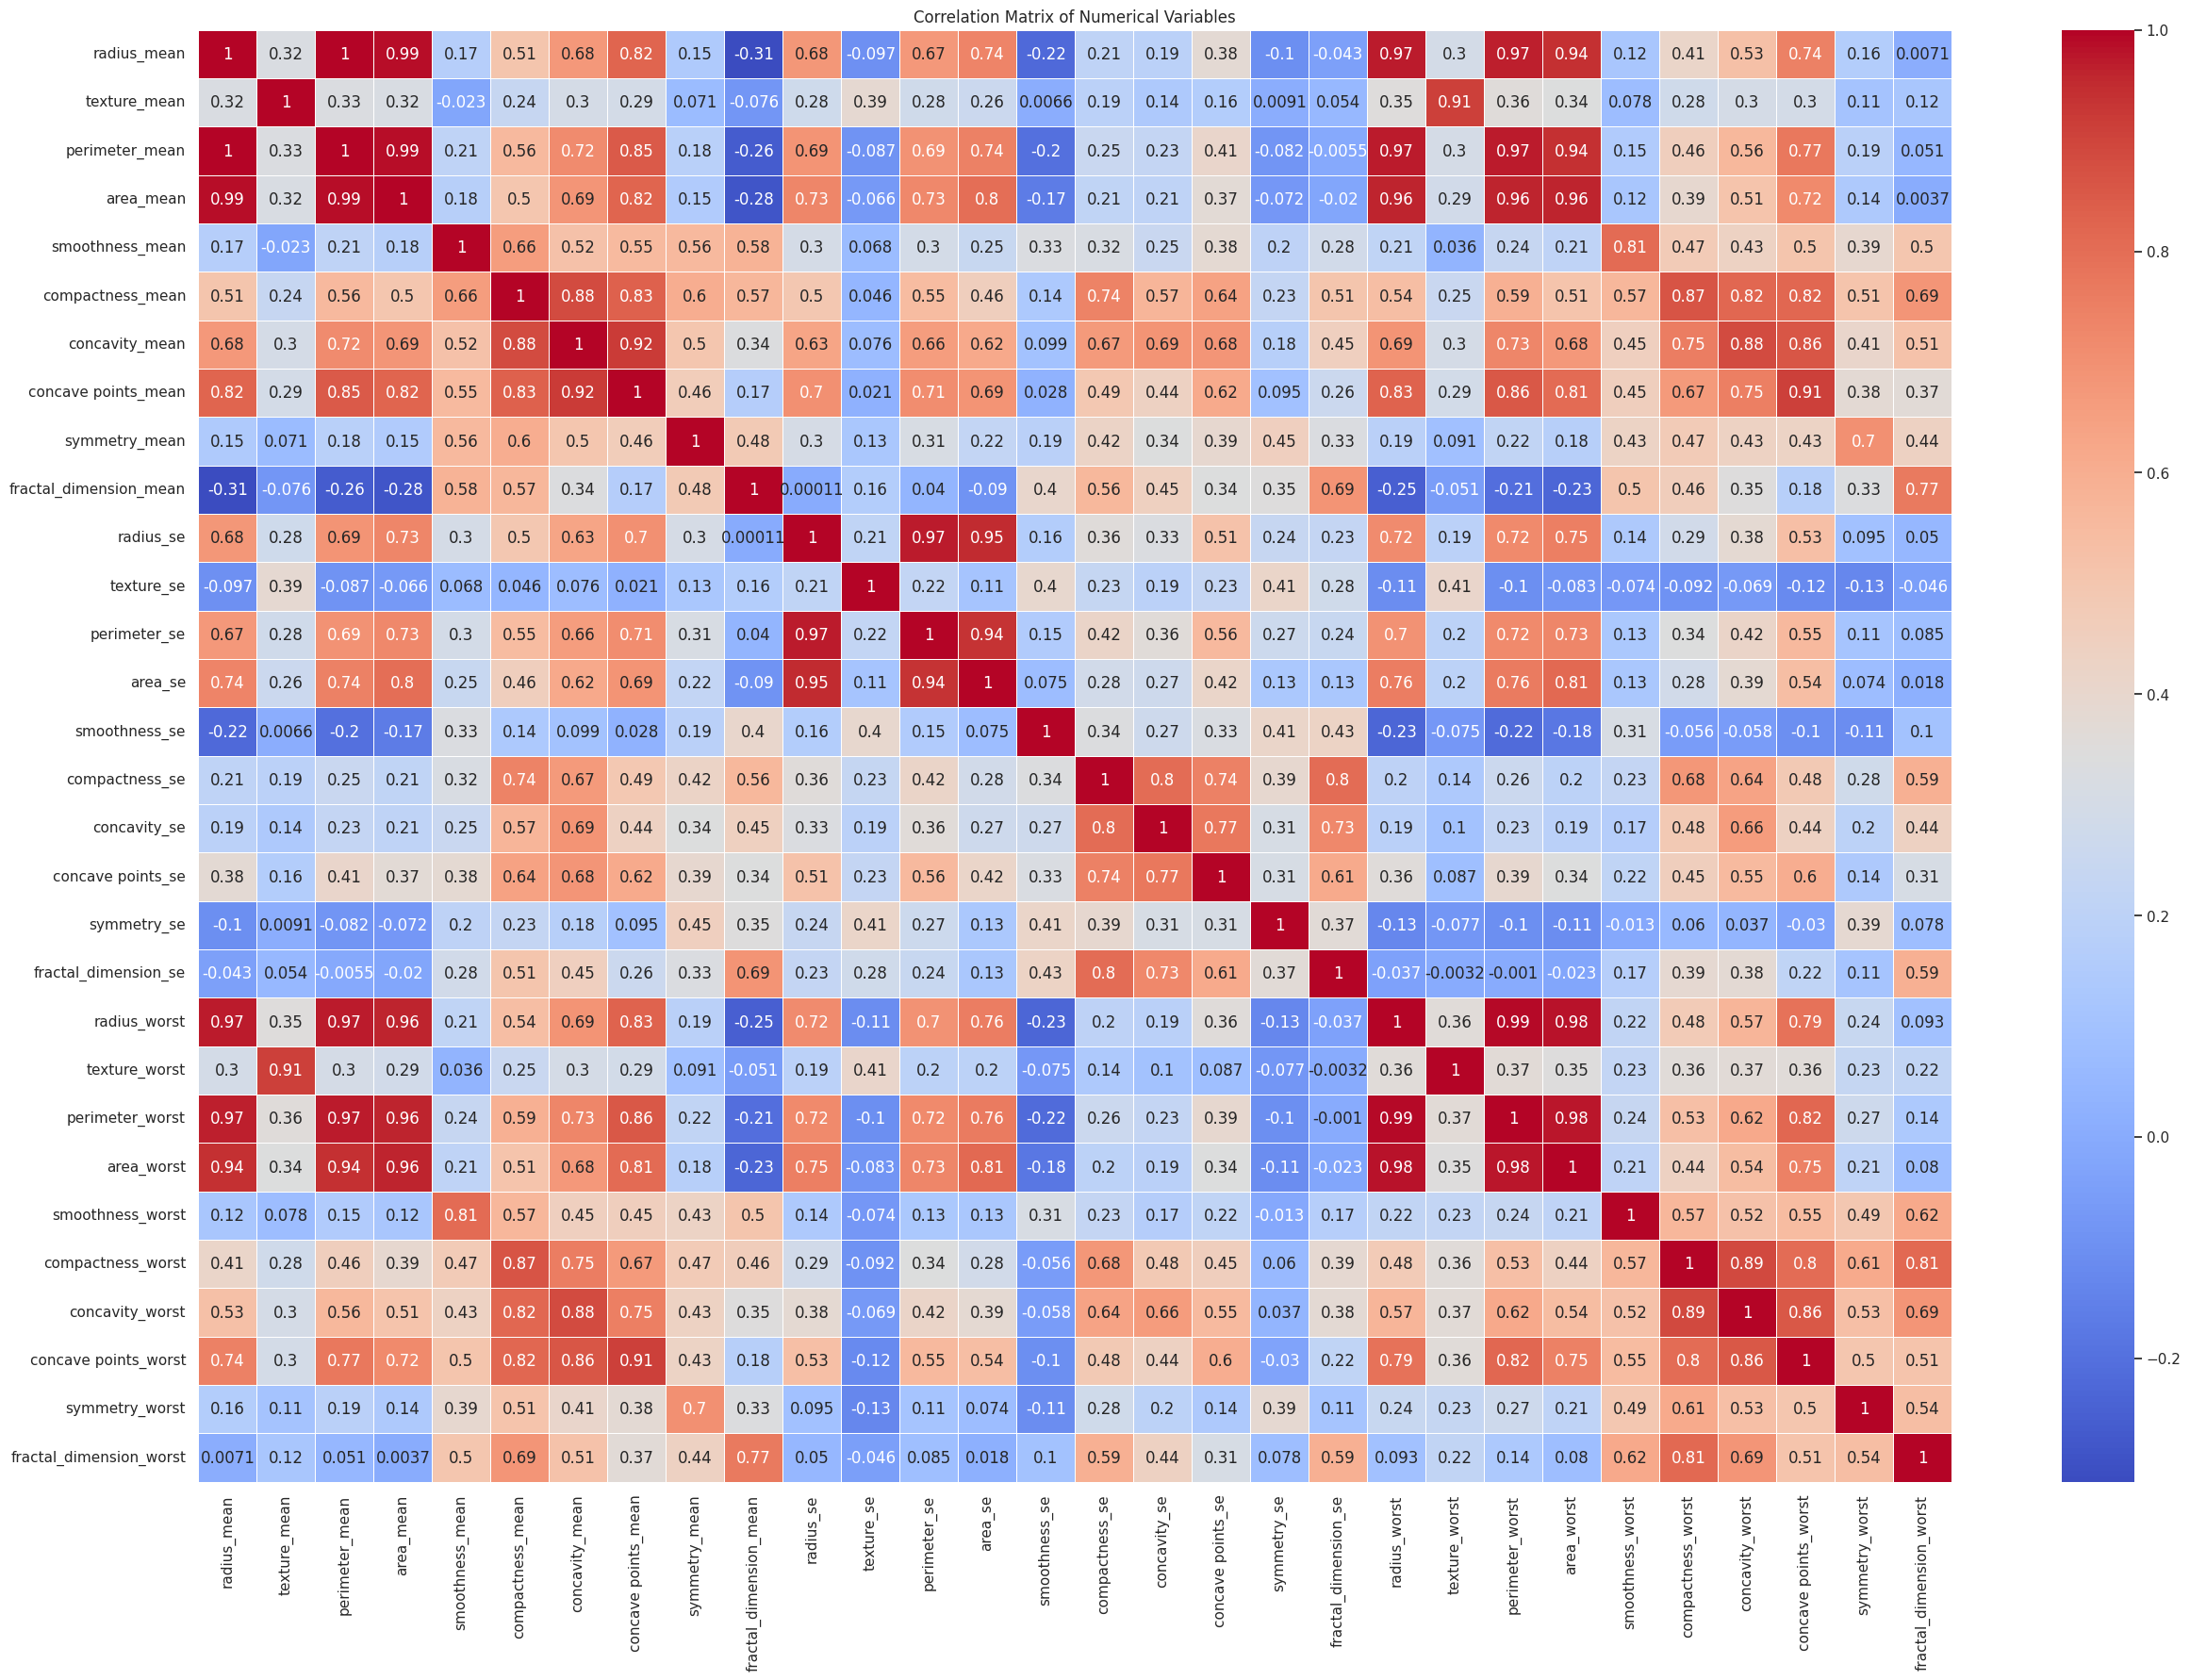

In [10]:
# based on AAI540 final project
# Correlation matrix & heatmap
correlation_matrix = raw_data[numeric_cols].corr()

plt.figure(figsize=(30, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

## Model Design and Building
Some of this code in this section is from or based on the following:

Pattanayak, S. (2021). Quantum Machine Learning with Python. New York, NY: Singer Science+Business Media.

### Sample quantum computing
Try out some examples to ensure the environment is setup correctly.

In [11]:
# Google's example- make sure the quantum simulation works
# https://quantumai.google/cirq/start/start

#import cirq

# Pick a qubit.
qubit = cirq.GridQubit(0, 0)

# Create a circuit
circuit = cirq.Circuit(
    cirq.X(qubit)**0.5,  # Square root of NOT.
    cirq.measure(qubit, key='m')  # Measurement.
)
print("Circuit:")
print(circuit)

# Simulate the circuit several times.
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=20)
print("Results:")
print(result)

Circuit:
(0, 0): ───X^0.5───M('m')───
Results:
m=11010011000110101011


### Normalize the data

In [12]:
# normalize the data
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the numeric columns
normalized_data = pd.DataFrame(scaler.fit_transform(raw_data[numeric_cols]), columns=numeric_cols)
normalized_data[TARGET_COL_BINARY] = raw_data[TARGET_COL_BINARY]

# Display the first few rows of the normalized data
display(normalized_data.head())

radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0     1.097064     -2.073335        1.269934   0.984375         1.568466   
1     1.829821     -0.353632        1.685955   1.908708        -0.826962   
2     1.579888      0.456187        1.566503   1.558884         0.942210   
3    -0.768909      0.253732       -0.592687  -0.764464         3.283553   
4     1.750297     -1.151816        1.776573   1.826229         0.280372   

   compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
0          3.283515        2.652874             2.532475       2.217515   
1         -0.487072       -0.023846             0.548144       0.001392   
2          1.052926        1.363478             2.037231       0.939685   
3          3.402909        1.915897             1.451707       2.867383   
4          0.539340        1.371011             1.428493      -0.009560   

   fractal_dimension_mean  ...  texture_worst  perimeter_worst  area_worst  \
0                2.255747  ...      -1.359293         2.303601    2.001237   
1               -0.868652  ...      -0.369203         1.535126    1.890489   
2               -0.398008  ...      -0.023974         1.347475    1.456285   
3                4.910919  ...       0.133984        -0.249939   -0.550021   
4               -0.562450  ...      -1.466770         1.338539    1.220724   

   smoothness_worst  compactness_worst  concavity_worst  concave points_worst  \
0          1.307686           2.616665         2.109526              2.296076   
1         -0.375612          -0.430444        -0.146749              1.087084   
2          0.527407           1.082932         0.854974              1.955000   
3          3.394275           3.893397         1.989588              2.175786   
4          0.220556          -0.313395         0.613179              0.729259   

   symmetry_worst  fractal_dimension_worst  diagnosis_binary  
0        2.750622                 1.937015                 1  
1       -0.243890                 0.281190                 1  
2        1.152255                 0.201391                 1  
3        6.046041                 4.935010                 1  
4       -0.868353                -0.397100                 1  

[5 rows x 31 columns]

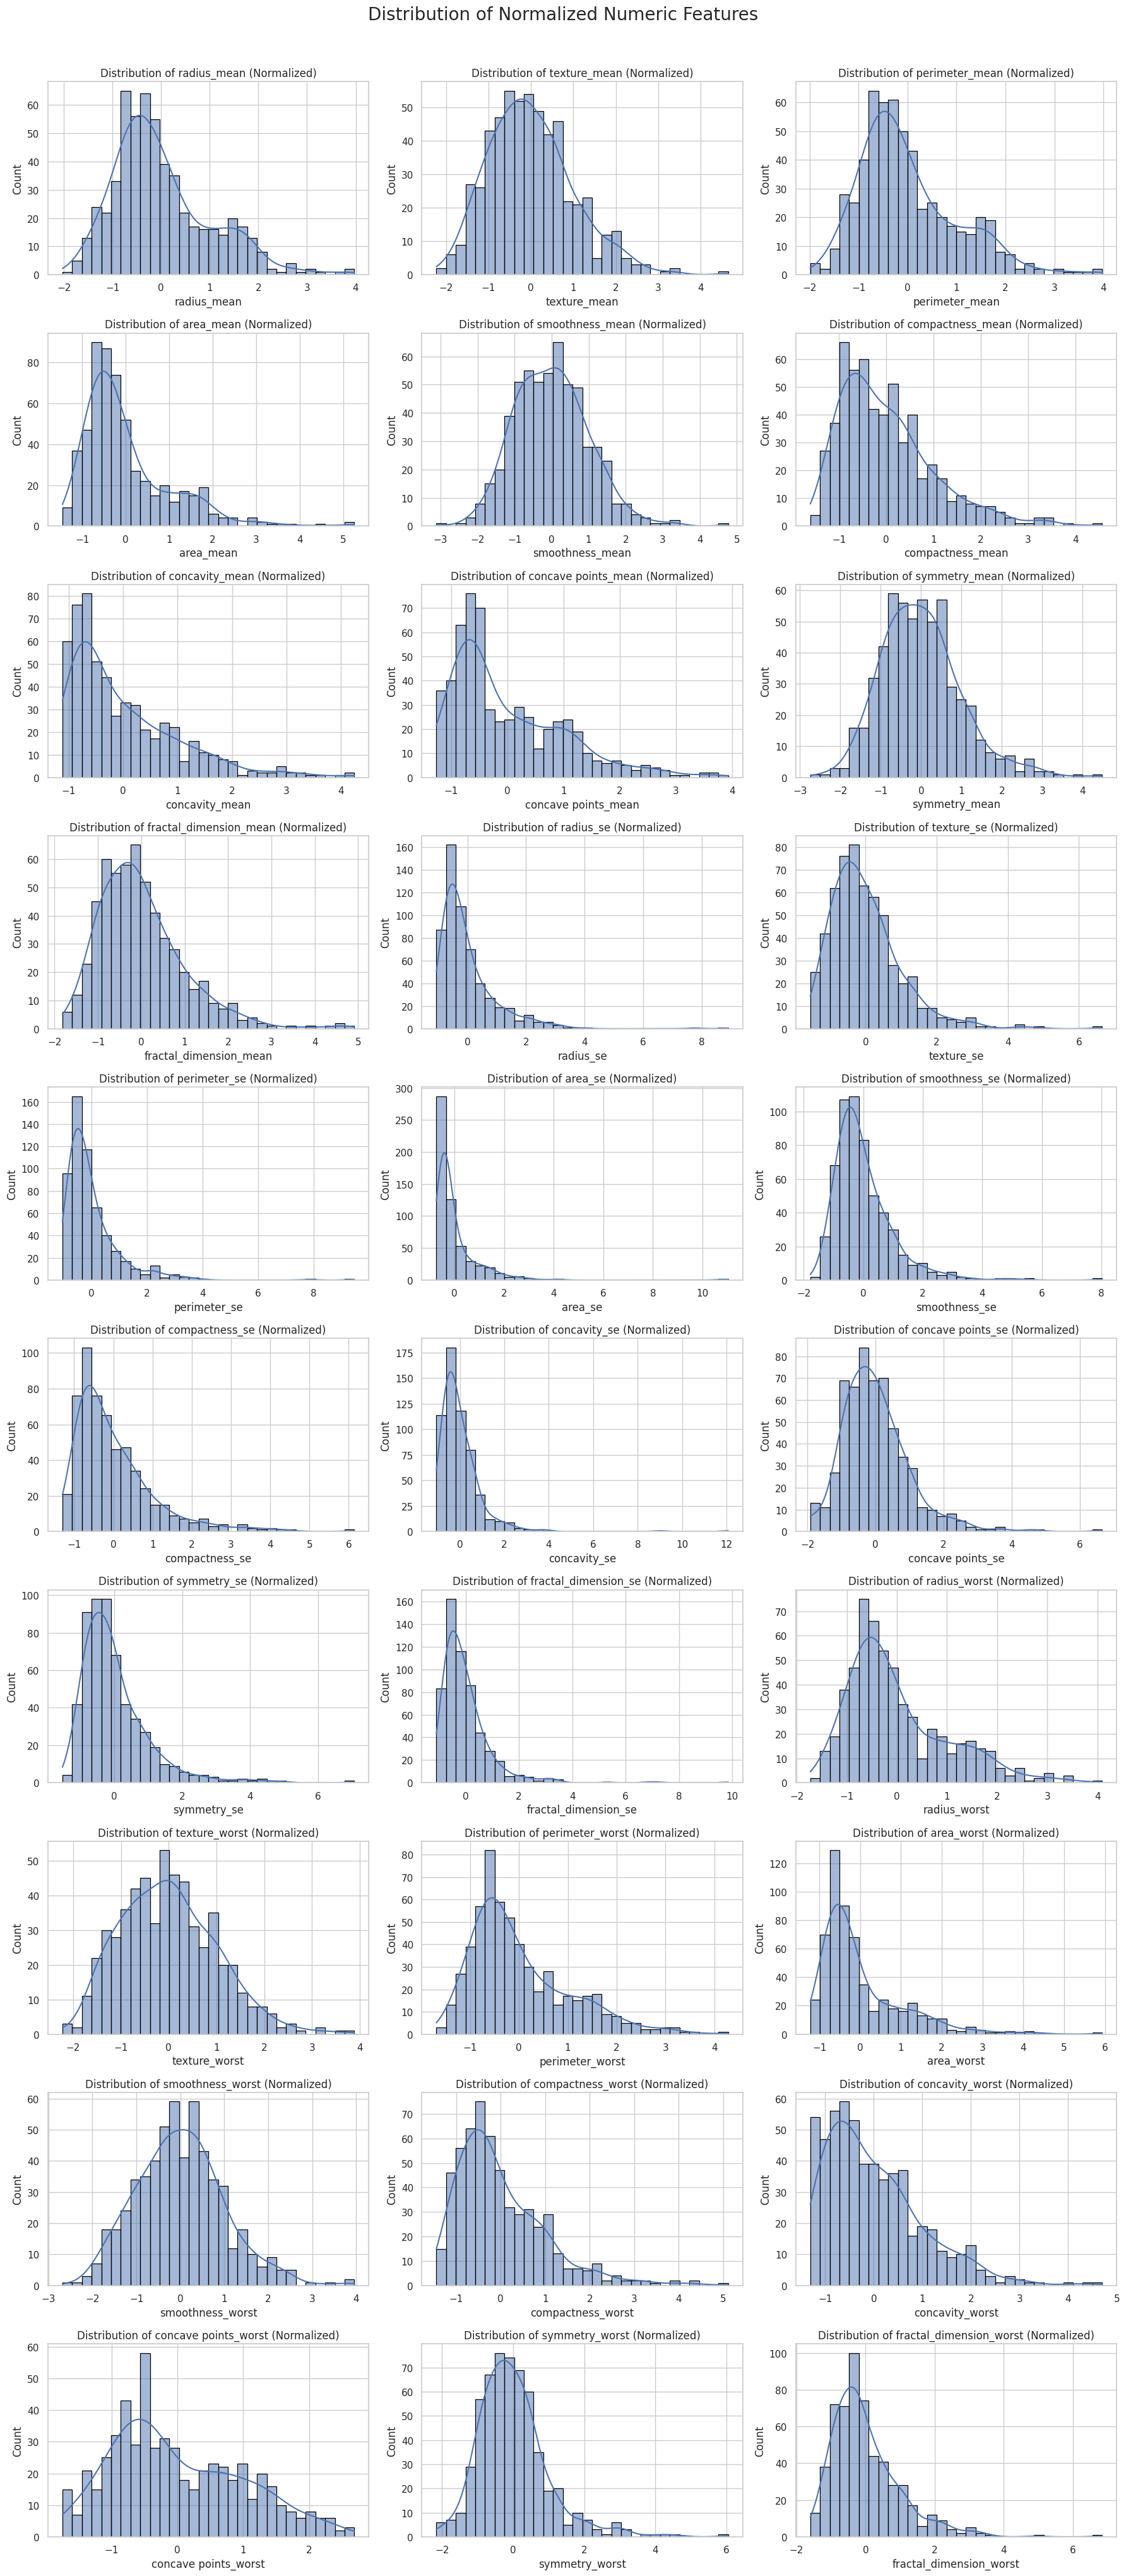

In [13]:
# prompt: How do I see the distribution of each column in normalized_data?

# Plot distributions for normalized data
sns.set(style="whitegrid")

# Set up the grid
num_plots = len(numeric_cols)
rows = (num_plots // 3) + (num_plots % 3 > 0)
fig, axes = plt.subplots(rows, 3, figsize=(18, 4 * rows))
axes = axes.flatten()

# Plot distributions
for i, col in enumerate(numeric_cols):
    sns.histplot(normalized_data[col], kde=True, ax=axes[i], bins=30, edgecolor='black')
    axes[i].set_title(f'Distribution of {col} (Normalized)')

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Distribution of Normalized Numeric Features", fontsize=20, y=1.02)
plt.show()

In [14]:
# There are a limited number of qubits we can use, so let's do feature selection
# to narrow things down. Methodology: each type of data has 3 variant features,
# [x]_mean, [x]_se, [x]_worst
MEAN_FEATURES = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', \
                 'smoothness_mean', 'compactness_mean', 'concavity_mean', \
                 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']

## Setup for quantum neural network (QNN)
Steps:
 1. Feature selection
 2. Down sample < 0 to 0, >= 1 to 1
 3. Remove duplicates with conflicting targets
 4. Split into test and train
 5. Quantum feature map
 6. Setup the QNN

In [15]:
# narrow down the data set based on the selected features
def narrow_features(all_data = normalized_data, feature_column_names = MEAN_FEATURES, target_column_name = TARGET_COL_BINARY, debug = False):
  cur_data = all_data[feature_column_names + [target_column_name]].copy()
  if debug:
    print(cur_data.head())

  return cur_data

In [46]:
# prompt: I want to take each column in cur_data and transform the value to 0
# if it the value is < 0 and transform it to 1 if the value is >= 0.
def transform_to_binary(cur_data, target_column_name = TARGET_COL_BINARY, debug = False):
  # map all the features into 0 and 1
  feature_cols = [col for col in cur_data.columns if col != TARGET_COL_BINARY]
  for col in feature_cols:
    cur_data[col] = cur_data[col].apply(lambda x: 0 if x < 0 else 1)

  # map the target to -1 (0) and 1 (1) for the hinge loss function later
  cur_data[target_column_name] = cur_data[target_column_name].apply(lambda x: -1 if x == 0 else 1)

  if debug:
    print(cur_data.tail())

  return cur_data

In [17]:
# prompt: I want to drop any rows in cur_data that have all the same values
# for the columns in MEAN_FEATURES but have different values for TARGET_COL_BINARY

# Identify rows that have the same values for MEAN_FEATURES but different values for TARGET_COL_BINARY
# Group by the
def remove_duplicates(cur_data, feature_columns = MEAN_FEATURES, target_column_name = TARGET_COL_BINARY, debug = False):
  grouped = cur_data.groupby(feature_columns)

  # Filter groups that have more than one unique value in TARGET_COL_BINARY
  conflict_groups = grouped.filter(lambda x: x[target_column_name].nunique() > 1)

  # Get the indices of these rows
  conflict_indices = conflict_groups.index

  # Drop these rows from the original DataFrame
  cur_data_cleaned = cur_data.drop(conflict_indices)

  if debug:
    print(f"Original data shape: {cur_data.shape}")
    print(f"Rows dropped due to conflicting targets: {len(conflict_indices)}")
    print(f"Cleaned data shape: {cur_data_cleaned.shape}")
    print(f"Target counts: {cur_data_cleaned[target_column_name].value_counts()}")

  # Optional: Verify by checking if any remaining group has conflicting targets
  grouped_cleaned = cur_data_cleaned.groupby(feature_columns)
  conflict_groups_cleaned = grouped_cleaned.filter(lambda x: x[target_column_name].nunique() > 1)

  if debug:
    if not conflict_groups_cleaned.empty:
      print("\nWarning: Conflicting targets found in the cleaned data.")
    else:
      print("\nSuccessfully removed rows with conflicting targets for same feature values.")

  cur_data = cur_data_cleaned.copy() # Update cur_data to the cleaned version
  return cur_data

In [18]:
# split into test and train
TESTING_PERCENTAGE = 0.2
RANDOM_STATE = 42

def split_data(cur_data, feature_columns = MEAN_FEATURES, target_column_name = TARGET_COL_BINARY, testing_percentage = TESTING_PERCENTAGE, random_state = RANDOM_STATE):
  # Use random_state for reproducibility
  cur_data = cur_data.sample(frac=1, random_state=RANDOM_STATE)  # shuffle it
  X_train, X_test, y_train, y_test = train_test_split(cur_data[feature_columns], cur_data[target_column_name], test_size=testing_percentage, random_state=random_state)
  return X_train, X_test, y_train, y_test

In [19]:
# quantum feature mapping
def quantum_feature_map(x):
  qubits = cirq.GridQubit.rect(1, len(x))
  circuit = cirq.Circuit()
  for i, val in enumerate(x):
    if val:
      circuit.append(cirq.X(qubits[i]))
  return circuit

In [20]:
# next create the quantum data set by doing the quantum feature
# mapping for each row in cur_data
# Iterate over the index of the DataFrame instead of a range
def convert_data_to_quantum(X_train, X_test, y_train, y_test, feature_column_names = MEAN_FEATURES, debug = False):
  X_train_quantum = [quantum_feature_map(X_train.loc[i, feature_column_names]) for i in X_train.index]
  X_test_quantum = [quantum_feature_map(X_test.loc[i, feature_column_names]) for i in X_test.index]

  # Convert the lists of Cirq circuits to TensorFlow tensors
  X_train_quantum = tfq.convert_to_tensor(X_train_quantum)
  X_test_quantum = tfq.convert_to_tensor(X_test_quantum)

  # be sure to add in the target
  # Since quantum_data is a tensor, we cannot add a column like to a DataFrame.
  # We need to keep the target values separately, aligned with the quantum data.
  y_train_quantum = y_train.values
  y_test_quantum = y_test.values

  # let's take a look
  if debug:
    print("Snippet of X_train_quantum:", X_train_quantum[ : 5])
    print()
    print("Snippet of X_test_quantum:", X_test_quantum[ : 5])
    print()
    # Note: these should be mapped to -1 xor 1, not 0 xor 1.
    print("Snippet of y_train_quantum:", y_train_quantum[ : 5])
    print()
    print("Snippet of y_test_quantum:", y_test_quantum[ : 5])

  return X_train_quantum, X_test_quantum, y_train_quantum, y_test_quantum

** From the MNIST proof of concept and example **

In [21]:
class QuantumLayer():
  def __init__(self, data_qubits, readout):
    self.data_qubits = data_qubits
    self.readout = readout

  def add_layer(self, circuit, gate, prefix):
    for i, q in enumerate(self.data_qubits):
      _w_ = sympy.Symbol(prefix + '-' + str(i))
      circuit.append(gate(q, self.readout) ** _w_)

In [22]:
def create_QNN(num_features):
  """ Create a QNN model circuit and prediction(readout) """
  data_qubits = cirq.GridQubit.rect(1, num_features)
  readout = cirq.GridQubit(-1, 1)    # a single qubit at [-1, 1]
  circuit = cirq.Circuit()

  # prep the readout qubit
  circuit.append(cirq.X(readout))
  circuit.append(cirq.H(readout))

  builder = QuantumLayer(data_qubits = data_qubits, readout = readout)

  # apply a series of XX layers followed by a series
  # of ZZ layers
  builder.add_layer(circuit, cirq.XX, 'XX')
  builder.add_layer(circuit, cirq.ZZ, 'ZZ')

  # Hadamard gate on the readout qubit
  circuit.append(cirq.H(readout))

  return circuit, cirq.Z(readout)

In [23]:
def hinge_accuracy(y_true, y_pred):
  y_true = tf.squeeze(y_true) > 0.0
  y_pred = tf.squeeze(y_pred) > 0.0
  cost = tf.cast(y_true == y_pred, tf.float32)

  return tf.reduce_mean(cost)

In [24]:
def build_model(num_features):
  model_circuit, model_readout = create_QNN(num_features)
  model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(), dtype=tf.string),
      tfq.layers.PQC(model_circuit, model_readout),
  ])
  return model, model_circuit, model_readout


In [25]:
def compile_model(feature_column_names = MEAN_FEATURES, debug = False):
  model, model_circuit, model_readout = build_model(len(MEAN_FEATURES))
  model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy]
  )

  if debug:
    print("Circuit:")
    print(model_circuit)
    print()
    print("Readout Qubit:")
    print(model_readout)
    print()
    print(model.summary())

  return model

In [26]:
# Plot loss and accuracy over epochs
def plot_loss_and_accuracy(qnn_hist):
  plt.figure(figsize=(12, 6))

  # Plot loss
  plt.subplot(1, 2, 1)
  plt.plot(qnn_hist.history['loss'], label='Training Loss')
  plt.plot(qnn_hist.history['val_loss'], label='Validation Loss')
  plt.title('Loss Over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(qnn_hist.history['hinge_accuracy'], label='Training Accuracy')
  plt.plot(qnn_hist.history['val_hinge_accuracy'], label='Validation Accuracy')
  plt.title('Accuracy Over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()

## Model Training
This is training the model, primarily based off the MNIST example. After this, different variations will be tried to see if they improve performance.

In [27]:
# setup all the data and model

# feature selection
cur_data = narrow_features(all_data = normalized_data, feature_column_names = MEAN_FEATURES, target_column_name = TARGET_COL_BINARY, debug = True)

   radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0     1.097064     -2.073335        1.269934   0.984375         1.568466   
1     1.829821     -0.353632        1.685955   1.908708        -0.826962   
2     1.579888      0.456187        1.566503   1.558884         0.942210   
3    -0.768909      0.253732       -0.592687  -0.764464         3.283553   
4     1.750297     -1.151816        1.776573   1.826229         0.280372   

   compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
0          3.283515        2.652874             2.532475       2.217515   
1         -0.487072       -0.023846             0.548144       0.001392   
2          1.052926        1.363478             2.037231       0.939685   
3          3.402909        1.915897             1.451707       2.867383   
4          0.539340        1.371011             1.428493      -0.009560   

   fractal_dimension_mean  diagnosis_binary  
0                2.255747                 1  


In [28]:
# feature transformation
cur_data = transform_to_binary(cur_data = cur_data, target_column_name = TARGET_COL_BINARY, debug = True)

     radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
564            1             1               1          1                1   
565            1             1               1          1                1   
566            1             1               1          1                0   
567            1             1               1          1                1   
568            0             1               0          0                0   

     compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
564                 1               1                    1              0   
565                 0               1                    1              0   
566                 0               1                    1              0   
567                 1               1                    1              1   
568                 0               0                    0              0   

     fractal_dimension_mean  diagnosis_binary  
564                 

In [29]:
# remove duplicates after narrowing and transformation
cur_data = remove_duplicates(cur_data, feature_columns = MEAN_FEATURES, target_column_name = TARGET_COL_BINARY, debug = True)

Original data shape: (569, 11)
Rows dropped due to conflicting targets: 134
Cleaned data shape: (435, 11)
Target counts: diagnosis_binary
-1    271
 1    164
Name: count, dtype: int64

Successfully removed rows with conflicting targets for same feature values.


In [30]:
# split into test and train
X_train, X_test, y_train, y_test = split_data(cur_data, \
                                              feature_columns = MEAN_FEATURES, \
                                              target_column_name = TARGET_COL_BINARY, \
                                              testing_percentage = TESTING_PERCENTAGE, \
                                              random_state = RANDOM_STATE)

In [31]:
# convert into quantum data
X_train_quantum, X_test_quantum, y_train_quantum, y_test_quantum = convert_data_to_quantum(X_train, \
                                                                                           X_test, \
                                                                                           y_train, \
                                                                                           y_test, \
                                                                                           feature_column_names = MEAN_FEATURES, \
                                                                                           debug = True)

Snippet of X_train_quantum: tf.Tensor(
[b'\n\x0e\n\x0ctfq_gate_set\x12\xd5\x08\x08\x01\x12\xd0\x08\n\x87\x01\n\x04\n\x02XP\x12\x16\n\x0econtrol_qubits\x12\x04\n\x02\x1a\x00\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x12\x16\n\x0econtrol_values\x12\x04\n\x02\x1a\x00\x12\x13\n\x08exponent\x12\x07\n\x05\r\x00\x00\x80?\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\x00\x1a\x05\x12\x030_0\n\x87\x01\n\x04\n\x02XP\x12\x16\n\x0econtrol_qubits\x12\x04\n\x02\x1a\x00\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x12\x16\n\x0econtrol_values\x12\x04\n\x02\x1a\x00\x12\x13\n\x08exponent\x12\x07\n\x05\r\x00\x00\x80?\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\x00\x1a\x05\x12\x030_1\n\x87\x01\n\x04\n\x02XP\x12\x16\n\x0econtrol_qubits\x12\x04\n\x02\x1a\x00\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x12\x16\n\x0econtrol_values\x12\x04\n\x02\x1a\x00\x12\x13\n\x08exponent\x12\x07\n\x05\r\x00\x00\x80?\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x0

In [32]:
# finally, put together the model
model = compile_model(feature_column_names = MEAN_FEATURES, debug = True)

Circuit:
(-1, 1): ───X───H───XX──────────XX──────────XX──────────XX──────────XX──────────XX──────────XX──────────XX──────────XX──────────XX──────────ZZ──────────ZZ──────────ZZ──────────ZZ──────────ZZ──────────ZZ──────────ZZ──────────ZZ──────────ZZ──────────ZZ──────────H───
                    │           │           │           │           │           │           │           │           │           │           │           │           │           │           │           │           │           │           │           │
(0, 0): ────────────XX^(XX-0)───┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────ZZ^(ZZ-0)───┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────────
                                │           │           │           │           │           │           │           │           │                       │           │           │           │           │          

In [33]:
BATCH_SIZE = 16
NUM_EPOCHS = 20
VERBOSE = 1

qnn_hist = model.fit(
    X_train_quantum, y_train_quantum,
    validation_data=(X_test_quantum, y_test_quantum),
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=VERBOSE
)

results = model.evaluate(X_test_quantum, y_test_quantum)
print(results)
print()
print("Final test loss: {:.4f}".format(results[0]))
print("Final test accuracy: {:.4f}".format(results[1]))

Epoch 1/20
22/22 [==============================] - 2s 62ms/step - loss: 0.9907 - hinge_accuracy: 0.5379 - val_loss: 0.9782 - val_hinge_accuracy: 0.5878
Epoch 2/20
22/22 [==============================] - 1s 45ms/step - loss: 0.9834 - hinge_accuracy: 0.5540 - val_loss: 0.9730 - val_hinge_accuracy: 0.5774
Epoch 3/20
22/22 [==============================] - 1s 45ms/step - loss: 0.9782 - hinge_accuracy: 0.5540 - val_loss: 0.9663 - val_hinge_accuracy: 0.5878
Epoch 4/20
22/22 [==============================] - 1s 45ms/step - loss: 0.9718 - hinge_accuracy: 0.5521 - val_loss: 0.9582 - val_hinge_accuracy: 0.5878
Epoch 5/20
22/22 [==============================] - 1s 46ms/step - loss: 0.9636 - hinge_accuracy: 0.5511 - val_loss: 0.9487 - val_hinge_accuracy: 0.6086
Epoch 6/20
22/22 [==============================] - 1s 43ms/step - loss: 0.9542 - hinge_accuracy: 0.5578 - val_loss: 0.9349 - val_hinge_accuracy: 0.6086
Epoch 7/20
22/22 [==============================] - 1s 46ms/step - loss: 0.9406 - 

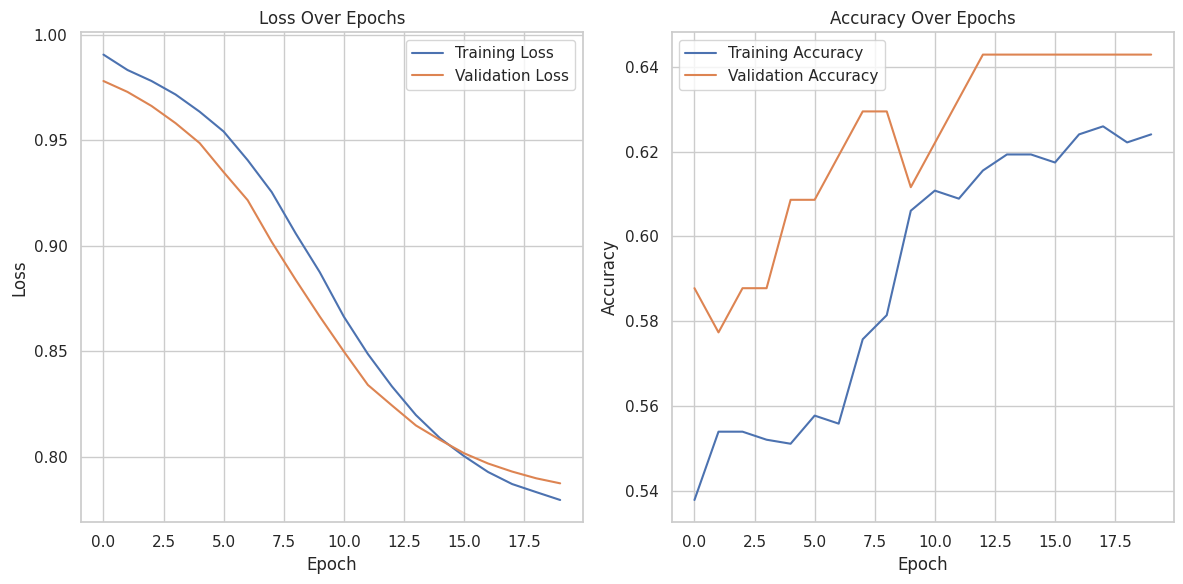

In [34]:
plot_loss_and_accuracy(qnn_hist)

Note the distribution, from above:
```
Target counts: diagnosis_binary
-1    271
 1    164
Name: count, dtype: int64
```
That breaks down to 62.3% for -1 (not cancer) and 37.7% for 1 (cancer).

## Model Optimization

There are several areas to try to optomize performance, as the original above isn't really performant. Those are:
 1. Different feature selection.
 2. Different feature engineering, as the above slots each feature value into a binary 0 or 1.
 3. Different quantum feature mapping (?).
 4. A different (deeper?) quantum neural network, including hyper parameters.

 In order to make the code easier to read, any new or derived functions utlized to atttempt model optimization are contained in the cells below.

 Approach being taken: try the above independently on top of the base model above. See if there are any significant improvements, and if so try to combine them too see if there is an overall better approach.

### Feature selection variations

In [49]:
VERBOSE = 0    # Keep the output compact- plenty of debug info above

#####################################################
# TODO: See what others have selected and try those #
#####################################################

# the other two buckets for each feature: SE (standard error) and worst
SE_FEATURES = ['radius_se', 'texture_se', 'perimeter_se', 'area_se', \
               'smoothness_se', 'compactness_se', 'concavity_se', \
               'concave points_se', 'symmetry_se', 'fractal_dimension_se']

WORST_FEATURES = ['radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', \
                  'smoothness_worst', 'compactness_worst', 'concavity_worst', \
                  'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']

# hand picked based on cold spots in the correlation matrix
# note: removed 'texture_se' for errors
SEEM_DIFFERENT_FEATURES = ['radius_mean', 'concavity_se', 'symmetry_mean', \
                           'smoothness_worst', 'symmetry_worst', \
                           'texture_worst', 'texture_mean', 'fractal_dimension_mean', \
                           'area_mean', 'radius_worst', 'smoothness_se', \
                           'perimeter_worst', 'texture_se']

# exponential slow down (?) with an increase in the features, need to keep
# that in mind. Example: combined mean and se and was running > 20 minutes, compared
# to just one or the other individually in less than a minute.
various_feature_selections = [WORST_FEATURES,
                              SE_FEATURES,
                              SEEM_DIFFERENT_FEATURES,
                              MEAN_FEATURES + SE_FEATURES]

for cur_feature_selections in various_feature_selections:
  print(datetime.now())
  cur_data = narrow_features(all_data = normalized_data, feature_column_names = cur_feature_selections, target_column_name = TARGET_COL_BINARY, debug = False)
  cur_data = transform_to_binary(cur_data = cur_data, target_column_name = TARGET_COL_BINARY, debug = False)
  cur_data = remove_duplicates(cur_data, feature_columns = cur_feature_selections, target_column_name = TARGET_COL_BINARY, debug = False)
  X_train, X_test, y_train, y_test = split_data(cur_data, \
                                                feature_columns = cur_feature_selections, \
                                                target_column_name = TARGET_COL_BINARY, \
                                                testing_percentage = TESTING_PERCENTAGE, \
                                                random_state = RANDOM_STATE)
  X_train_quantum, X_test_quantum, y_train_quantum, y_test_quantum = convert_data_to_quantum(X_train, \
                                                                                             X_test, \
                                                                                             y_train, \
                                                                                             y_test, \
                                                                                             feature_column_names = cur_feature_selections, \
                                                                                             debug = False)
  model = compile_model(feature_column_names = cur_feature_selections, debug = False)

  # train it
  qnn_hist = model.fit(
      X_train_quantum, y_train_quantum,
      validation_data=(X_test_quantum, y_test_quantum),
      batch_size=BATCH_SIZE,
      epochs=NUM_EPOCHS,
      verbose=VERBOSE
  )

  print("FEATURES SELECTED:")
  print(cur_feature_selections)
  print()
  results = model.evaluate(X_test_quantum, y_test_quantum)
  print(results)
  print()
  print("Final test loss: {:.4f}".format(results[0]))
  print("Final test accuracy: {:.4f}".format(results[1]))
  print("*****************************")
  print()

print(datetime.now())

2025-07-24 01:30:14.266120


/usr/local/lib/python3.11/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


FEATURES SELECTED:
['radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']

3/3 [==============================] - 0s 31ms/step - loss: 0.8934 - hinge_accuracy: 0.5646
[0.8934392333030701, 0.5645833611488342]

Final test loss: 0.8934
Final test accuracy: 0.5646
*****************************

2025-07-24 01:30:57.362211


/usr/local/lib/python3.11/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


FEATURES SELECTED:
['radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se']

2/2 [==============================] - 0s 35ms/step - loss: 0.6999 - hinge_accuracy: 0.7011
[0.6999417543411255, 0.7011088728904724]

Final test loss: 0.6999
Final test accuracy: 0.7011
*****************************

2025-07-24 01:31:15.585298


/usr/local/lib/python3.11/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


FEATURES SELECTED:
['radius_mean', 'concavity_se', 'symmetry_mean', 'smoothness_worst', 'symmetry_worst', 'texture_worst', 'texture_mean', 'fractal_dimension_mean', 'area_mean', 'radius_worst', 'smoothness_se', 'perimeter_worst', 'texture_se']

4/4 [==============================] - 0s 38ms/step - loss: 1.1023 - hinge_accuracy: 0.4418
[1.1022590398788452, 0.4417613744735718]

Final test loss: 1.1023
Final test accuracy: 0.4418
*****************************

2025-07-24 01:32:10.476912


/usr/local/lib/python3.11/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


FEATURES SELECTED:
['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se']

4/4 [==============================] - 5s 1s/step - loss: 1.1334 - hinge_accuracy: 0.4279
[1.1333739757537842, 0.42788460850715637]

Final test loss: 1.1334
Final test accuracy: 0.4279
*****************************

2025-07-24 01:59:40.125762


## Model Analysis

## Additional details

### Feature definitions
Additional details on the features, from the [source](https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset/discussion/528138).

 * id: A unique identifier for each tumor record.

 * diagnosis: The diagnosis of the tumor, where M stands for malignant and B stands for benign.

 * radius_mean: The mean of the distances from the center of the tumor to the perimeter. It reflects the average size of the tumor.
 * texture_mean: The mean of the standard deviation of gray-scale values in the tumor image. It measures the smoothness or coarseness of the tumor's texture.
 * perimeter_mean: The mean of the perimeter lengths of the tumor's boundary. It reflects the average circumference of the tumor.
 * area_mean: The mean of the area occupied by the tumor. It represents the average size of the tumor's surface area.
 * smoothness_mean: The mean of local variation in radius lengths, measuring how smooth the tumor's surface is.
 * compactness_mean: The mean of the compactness of the tumor. It indicates how compact or round the tumor is.
 * concavity_mean: The mean of the severity of concave portions of the tumor's boundary. It reflects the degree of inward curving of the tumor's edges.
 * concave points_mean: The mean of the number of concave portions of the tumor's boundary. It counts the number of indentations or concave points on the tumor's edge.
 * symmetry_mean: The mean of the symmetry of the tumor. It measures how symmetrical the tumor is about its center.
 * fractal_dimension_mean: The mean of the fractal dimension, reflecting how detailed the tumor's surface is.

 * radius_se: The standard error of the radius measurement.
 * texture_se: The standard error of the texture measurement.
 * perimeter_se: The standard error of the perimeter measurement.
 * area_se: The standard error of the area measurement.
 * smoothness_se: The standard error of the smoothness measurement.
 * compactness_se: The standard error of the compactness measurement.
 * concavity_se: The standard error of the concavity measurement.
 * concave points_se: The standard error of the concave points measurement.
 * symmetry_se: The standard error of the symmetry measurement.
 * fractal_dimension_se: The standard error of the fractal dimension measurement.

 * radius_worst: The worst (largest) value of the radius measurements across all the samples.
 * texture_worst: The worst (largest) value of the texture measurements across all the samples.
 * perimeter_worst: The worst (largest) value of the perimeter measurements across all the samples.
 * area_worst: The worst (largest) value of the area measurements across all the samples.
 * smoothness_worst: The worst (largest) value of the smoothness measurements across all the samples.
 * compactness_worst: The worst (largest) value of the compactness measurements across all the samples.
 * concavity_worst: The worst (largest) value of the concavity measurements across all the samples.
 * concave points_worst: The worst (largest) value of the concave points measurements across all the samples.
 * symmetry_worst: The worst (largest) value of the symmetry measurements across all the samples.
 * fractal_dimension_worst: The worst (largest) value of the fractal dimension measurements across all the samples.